In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

# 读取数据
original_data = pd.read_csv('data/China_carbon.csv')
print(original_data.shape)
original_data.head()

(1734, 9)


,date,country,total,Domestic Aviation,Ground Transport,Industry,International Aviation,Power,Residential
0,2019/1/1,China,32267.17281,163.041934,2521.742753,10417.410020,77.251815,14816.08812,4348.889984
1,2019/1/2,China,31713.30530,166.187507,2539.914472,10249.356120,78.098273,14577.07465,4180.772553
2,2019/1/3,China,30632.94268,163.077528,2529.741199,9936.428175,78.935910,14132.01507,3871.680702
3,2019/1/4,China,31433.26205,164.228209,2574.039463,10266.741010,78.922979,14601.80018,3826.453191
4,2019/1/5,China,31437.81250,159.385209,2514.699964,10260.946050,85.293996,14593.55833,3909.222941


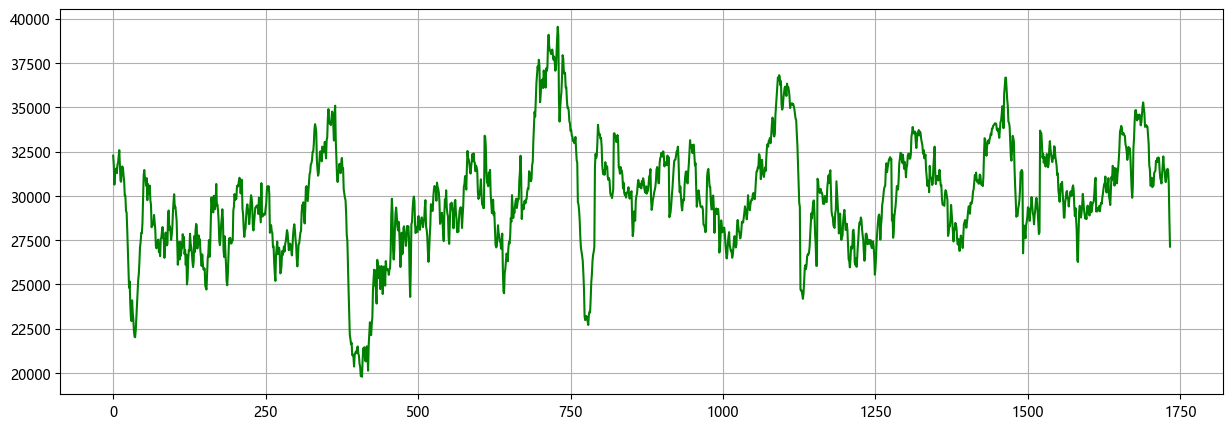

In [2]:
import pandas as pd
import datetime

# 由于数据集太大， 取前 6000条数据进行测试
original_data = original_data.iloc[0:6000]

# 取碳排放数据
carbonddata = original_data['total'].tolist()
# 可视化
plt.figure(figsize=(15,5), dpi=100)
plt.grid(True)
plt.plot(carbonddata, color='green')
plt.show()

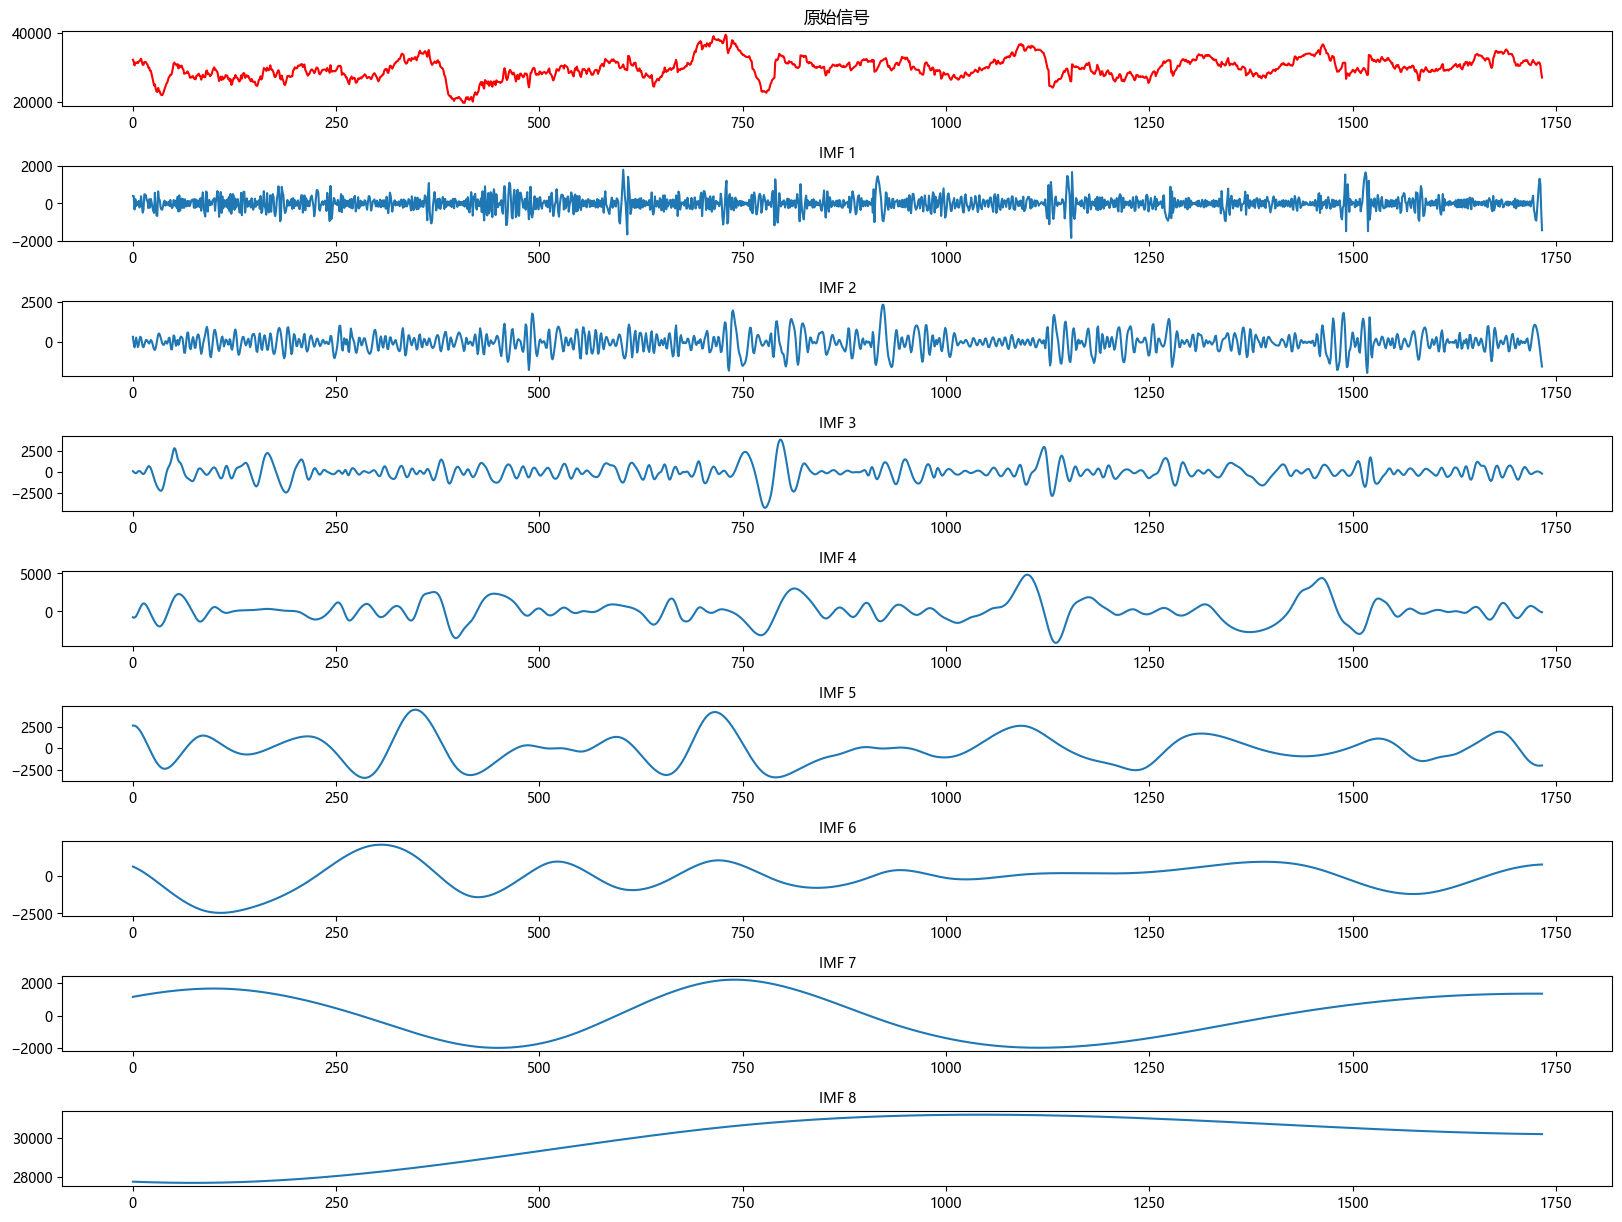

In [3]:
from PyEMD import EMD

# 创建 EMD 对象
emd = EMD()
# 对信号进行经验模态分解
carbonddata = np.array(carbonddata) # 转换为numpy
IMFs = emd(carbonddata)

# 可视化
plt.figure(figsize=(20,15))
plt.subplot(len(IMFs)+1, 1, 1)
plt.plot(carbonddata, 'r')
plt.title("原始信号")

for num, imf in enumerate(IMFs):
    plt.subplot(len(IMFs)+1, 1, num+2)
    plt.plot(imf)
    plt.title("IMF "+str(num+1), fontsize=10)
# 增加第一排图和第二排图之间的垂直间距
plt.subplots_adjust(hspace=0.8, wspace=0.2)
plt.show()

转置

In [4]:
# 保存数据
from joblib import dump, load

IMFs = IMFs.T
print(IMFs.shape)

# 分解出 10个 分量
# 保存数据
dump(IMFs, 'carbon_emd_imfs')

(1734, 8)


['carbon_emd_imfs']

In [5]:
# 制作数据集和标签
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 加载数据
from joblib import dump, load
wind_emd_imfs = load('carbon_emd_imfs')

# 归一化处理
# 使用标准化（z-score标准化）

scaler = StandardScaler()
wind_emd_imfs = scaler.fit_transform(wind_emd_imfs)
# 保存 归一化 模型
dump(scaler, 'scaler') 



# 这些转换是为了将数据和标签转换为PyTorch可以处理的张量
def make_data_labels(x_data, y_label):
    '''
        返回 x_data: 数据集     torch.tensor
            y_label: 对应标签值  torch.tensor
    '''
    # 信号值
    x_data = torch.tensor(x_data).float()
    # 标签值
    y_label = torch.tensor(y_label).float()
    return x_data, y_label


# 使用滑动窗口处理时间序列数据
def data_window_maker(time_series, window_size):
    '''
        参数:
        time_series: 数据集(为numpy数组格式)
        window_size: 滑动窗口大小
        ndim: 数组维度

        返回:
        data_x: 特征数据
        data_y: 标签数据
    '''
    # 用来存放输入特征
    data_x = []
    # 用来存放输出标签
    data_y = []
    # 构建训练集和对应标签
    data_len = time_series.shape[0]
    for i in range(data_len - window_size):
            data_x.append(time_series[i:i+window_size, :])  # 取前window_size个数据作为输入特征
            data_y.append(time_series[i+window_size, :])  # 取第window_size+1个数据作为输出标签
    

    # 将列表转换为单一的NumPy数组
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    # 转换为 tensor
    data_x, data_y = make_data_labels(data_x, data_y)
    return data_x, data_y


# 数据集制作
def make_wind_dataset(data, window_size, split_rate = [0.8, 0.2]):
    '''
        参数:
        data: 数据集(为numpy数组格式)
        window_size: 滑动窗口大小
        split_rate: 训练集、测试集划分比例

        返回:
        train_set: 训练集数据
        train_label: 训练集标签
        test_set: 测试集数据
        test_label: 测试集标签
    '''
    # 第一步，划分数据集
    sample_len = data.shape[0] # 样本总长度
    train_len = int(sample_len*split_rate[0])  # 向下取整
    train_data = data[:train_len, :] # 训练集
    test_data = data[train_len:, :]  # 测试集

    # 第二步，制作数据集标签  滑动窗口
    train_set, train_label = data_window_maker(train_data, window_size)
    test_set, test_label = data_window_maker(test_data, window_size)

    return train_set, train_label, test_set, test_label


# 定义滑动窗口大小
window_size = 7
# 制作数据集
train_set, train_label, test_set, test_label = make_wind_dataset(wind_emd_imfs, window_size)
# 保存数据
dump(train_set, 'c_train_set')
dump(train_label, 'c_train_label')
dump(test_set, 'c_test_set')
dump(test_label, 'c_test_label')

['c_test_label']

In [6]:
print('数据 形状：')
print(train_set.size(), train_label.size())
print(test_set.size(), test_label.size())

# 解释：10个输入维度 去 滑动预测 一个风速
# 变量 序列长度为 7 , 预测一个 值 （单步预测）

数据 形状：
torch.Size([1380, 7, 8]) torch.Size([1380, 8])
torch.Size([340, 7, 8]) torch.Size([340, 8])


In [ ]:
#输出imf
from PyEMD import EMD

# 创建 EMD 对象
emd = EMD()
# 对信号进行经验模态分解
carbonddata = np.array(carbonddata) # 转换为numpy
IMFs = emd(carbonddata)

# 可视化
plt.figure(figsize=(20,15))
plt.subplot(len(IMFs)+1, 1, 1)
plt.plot(carbonddata, 'r')
plt.title("原始信号")

for num, imf in enumerate(IMFs):

    plt.subplot(len(IMFs)+1, 1, num+2)
    plt.plot(imf)
    plt.title("IMF "+str(num+1), fontsize=10)
# 增加第一排图和第二排图之间的垂直间距
plt.subplots_adjust(hspace=0.8, wspace=0.2)
plt.show()
